**EC3310 Final Project Script: Candidate numbers: 2107622, 2106445, 2107870 Candidate names: Mohammed Arifur Rahman, Alirida Shugaa, Don Dervishi** 

In [1]:
pip install quandl 

^Required to install quandl for the first time

In [2]:
#Imports all packages
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd
import requests
import re
import json
import quandl
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

Section 1: Interest Rate Data Acquisition via API

In [3]:
quandl.ApiConfig.api_key = "21zHsYK7gkPQWCpzQHdc" #Unique API key

UK_quand=quandl.get("BOE/IUALBEDR", authtoken=quandl.ApiConfig.api_key, start_date="2015-12-31", end_date="2019-12-31", returns="numpy")
#Uses built-in function from data package to recall annual Base rate data from online database as a numpy array with specified start/end dates
UK_int=pd.DataFrame(UK_quand) #Builds DataFrame from numpy array

US_quand=quandl.get("FED/FL072052006_A", authtoken=quandl.ApiConfig.api_key, start_date="2015-12-31", end_date="2019-12-31", returns="numpy")
US_int=pd.DataFrame(US_quand) #Same for the United State database (Russia not available in quandl)


Section 2: Interest Rate Data Acquisition via Data Scraping

In [4]:
url="https://www.cbr.ru/eng/hd_base/KeyRate/?UniDbQuery.Posted=True&UniDbQuery.From=31%2F12%2F2015&UniDbQuery.To=31%2F12%2F2019"
page=requests.get(url) #Uses requests function to obtain URL data
soup=BeautifulSoup(page.content, 'html.parser') #Translates and returns data in HTML format
rows=soup.find_all('tr') #Generates a list of all instances for 'tr' which denotes each row of the table
row_list=[] #Empty list to help count rows
for i in range(1,len(rows)): 
    find=rows[i].find_all('td') #Returns the values in each row (2 per row) while retaining the original (table) formatting
    for n in range(len(find)): #Iterates for the number of rows
        find[n]=str(find[n]) #Converts into a string for charapcter manipulation
        find[n]=find[n].replace('<td>', '') #Removes any instances of <td> and </td>
        find[n]=find[n].replace('</td>', '')
    find[1]=float(find[1]) #Converts all values from the 2nd row onwards into floats (1st row is the table head)
    row_list.append(find) #Appends all entries into the complete row list
    
RUS_int=pd.DataFrame(row_list, columns=['Date', 'Value']) #Generates DataFrame from list 
RUS_int['Date']=pd.to_datetime(RUS_int['Date']) #Changes all values in the Date column into datetime  

int_list=[RUS_int.iloc[989],RUS_int.iloc[741],RUS_int.iloc[494],RUS_int.iloc[248],RUS_int.iloc[0]] 
#Creates a new list of rows which correspond to the final date in each year. 
#Indexes were found using the dates below and a boolean operator since there are 989 rows
RUS_int=pd.DataFrame(int_list, columns=['Date', 'Value'], index=range(5)) #Generates DataFrame from new list 

#End of year dates (Russian Central bank data was very inconsistent visit URL for more information)
#2019-12-31
#2018-12-28
#2017-12-29
#2016-12-30
#2015-12-31

Section 3: Military Expenditure Data Function via Data Scraping

In [5]:
#Mil Expenditure Data Scrape:
def Mil_Exp(url): #Defines function
    """
    inputs: A string  
    output: A dataframe 
    A function that takes a URL and generates a dataframe showing the national Military Expenditure from 2015-2019:
    """  
    page=requests.get(url) #Uses requests function to obtain URL data
    soup=BeautifulSoup(page.content, 'html.parser')
    rows=soup.find_all('tbody') #Generates a list of all instances of tbody (since there are multiple tables on the webpage and the desired table is the 2nd of the two)
    td=[] #Empty lists to help count
    date_list=[]
    val_list=[]
    tr=rows[1].find_all('tr') #Generates a new list of all instances of tr within tbody denoting the data contained in each row while retaining the original format
    for n in range(6): #Iterates for 6 rows (instead of 5 due to inconsistencies in formatting for Russian data)
        td.append(tr[n].find_all('td')) #Generates a list of all instances of td and appends onto empty list in the original format
        td[n][1]=td[n][1].text.replace('$', '') #Returns the 2nd column of the nth position in the list as text and removes the symbol
        td[n][1]=td[n][1].replace('B', '') #The nth position in the row represents the nth row in the table
        date_list.append(td[n][0].text) #Appends the 1st column (Date) of the nth row as text onto a new list
        val_list.append(float(td[n][1])) #Appends the 2nd column (Expenditure) of the nth row as text onto a new list
    data={'Year':date_list, 'Billions (USD)':val_list } #Creates a dictionary to compile all information
    Mil=pd.DataFrame(data).iloc[::-1] #Genrates Dataframe from dictionary and also reverses the index (chronological order)
    Mil=Mil.apply(pd.to_numeric, errors='coerce') #Turns every value into a float and creates an error where N/A
    Mil=Mil.dropna() #Deletes all NaN rows (Used to get rid of 1st null row in Russian data table)
    Mil['Year']=pd.to_numeric(Mil['Year'], downcast='integer') #Reassigns the year column to be integers
    Mil=Mil.tail(5) #Takes the last 5 values in the table (which after reversal is 2015-2019)
    Mil=Mil.reset_index(drop=True) #Resets the index after index reversal and deletion
    return Mil #Output

url_1="https://www.macrotrends.net/countries/GBR/united-kingdom/military-spending-defense-budget" #URLs for each nation
url_2="https://www.macrotrends.net/countries/USA/united-states/military-spending-defense-budget"
url_3="https://www.macrotrends.net/countries/RUS/russia/military-spending-defense-budget" #Visit URL to see the 1st row of the right table

UK_Mil=Mil_Exp(url_1) #Executes the custom function on a URL and assigns it to the corresponding database
US_Mil=Mil_Exp(url_2)
RUS_Mil=Mil_Exp(url_3)

Section 4: Data Tabulation

In [6]:
UK_data={'Year':UK_Mil['Year'],'Interest Rate':UK_int['Value'],'Expenditure (USD Billions)':UK_Mil['Billions (USD)']} #Generates Dictionary
UK_tab=pd.DataFrame(UK_data) #Generates Compilied Dataframe from dictionary
UK_tab

,Year,Interest Rate,Expenditure (USD Billions)
0,2015,0.50,53.86
1,2016,0.25,48.12
2,2017,0.50,46.43
3,2018,0.75,49.89
4,2019,0.75,48.65


In [7]:
US_data={'Year':US_Mil['Year'],'Interest Rate':US_int['Value'],'Expenditure (USD Billions)':US_Mil['Billions (USD)']} #Generates Dictionary
US_tab=pd.DataFrame(US_data) #Generates Compilied Dataframe from dictionary
US_tab

,Year,Interest Rate,Expenditure (USD Billions)
0,2015,0.24,633.83
1,2016,0.54,639.86
2,2017,1.30,646.75
3,2018,2.27,682.49
4,2019,1.55,731.75


In [8]:
RUS_data={'Year':RUS_Mil['Year'],'Interest Rate':RUS_int['Value'],'Expenditure (USD Billions)':RUS_Mil['Billions (USD)']} #Generates Dictionary
RUS_tab=pd.DataFrame(RUS_data) #Generates Compilied Dataframe from dictionary
RUS_tab

,Year,Interest Rate,Expenditure (USD Billions)
0,2015,11.00,66.42
1,2016,10.00,69.25
2,2017,7.75,66.53
3,2018,7.75,61.39
4,2019,6.25,65.10


Section 5: Basic Data Analysis

In [9]:
UK_int_mean=UK_tab['Interest Rate'].mean() #Computes the mean for the column 
UK_Mil_mean=UK_tab['Expenditure (USD Billions)'].mean()
UK_int_max=UK_tab['Year'][UK_tab['Interest Rate'].idxmax()]#Computes the index of the highest 'Interest Rate' and returns the year of the index
UK_Mil_max=UK_tab['Year'][UK_tab['Expenditure (USD Billions)'].idxmax()] #Computes the index of the maximum Expenditure and returns the year of the index
UK_int_min=UK_tab['Year'][UK_tab['Interest Rate'].idxmin()] #Computes the index of the lowest 'Interest Rate' and returns the year of the index
UK_Mil_min=UK_tab['Year'][UK_tab['Expenditure (USD Billions)'].idxmin()] #Computes the index of the minimum in Expenditure and returns the year of the index

US_int_mean=US_tab['Interest Rate'].mean() #The same has been computed for the other two nations
US_Mil_mean=US_tab['Expenditure (USD Billions)'].mean()
US_int_max=US_tab['Year'][US_tab['Interest Rate'].idxmax()]
US_Mil_max=US_tab['Year'][US_tab['Expenditure (USD Billions)'].idxmax()]
US_int_min=US_tab['Year'][US_tab['Interest Rate'].idxmin()]
US_Mil_min=US_tab['Year'][US_tab['Expenditure (USD Billions)'].idxmin()]

RUS_int_mean=RUS_tab['Interest Rate'].mean()
RUS_Mil_mean=RUS_tab['Expenditure (USD Billions)'].mean()
RUS_int_max=RUS_tab['Year'][RUS_tab['Interest Rate'].idxmax()]
RUS_Mil_max=RUS_tab['Year'][RUS_tab['Expenditure (USD Billions)'].idxmax()]
RUS_int_min=RUS_tab['Year'][RUS_tab['Interest Rate'].idxmin()]
RUS_Mil_min=RUS_tab['Year'][RUS_tab['Expenditure (USD Billions)'].idxmin()]

In [10]:
index_list=['Mean:', 'Maximum Year:', 'Minimum Year:'] #Creates lists to help simplify dictionary
UK_int_list=[UK_int_mean, UK_int_max, UK_int_min]
UK_Mil_list=[UK_Mil_mean, UK_Mil_max, UK_Mil_min]
UK_base={'Interest Rate':UK_int_list, 'Expenditure (USD Billions)':UK_Mil_list} #Generates Dictionary
UK_basic=pd.DataFrame(UK_base, index=[index_list]) #Generates Compilied Dataframe from dictionary
UK_basic

,Interest Rate,Expenditure (USD Billions)
Mean:,0.55,49.39
Maximum Year:,2018.00,2015.00
Minimum Year:,2016.00,2017.00


In [11]:
index_list=['Mean:', 'Maximum Year:', 'Minimum Year:'] #Creates lists to help simplify dictionary
US_int_list=[US_int_mean, US_int_max, US_int_min]
US_Mil_list=[US_Mil_mean, US_Mil_max, US_Mil_min]
US_base={'Interest Rate':US_int_list, 'Expenditure (USD Billions)':US_Mil_list}
US_basic=pd.DataFrame(US_base, index=[index_list]) #Generates Compilied Dataframe from dictionary
US_basic

,Interest Rate,Expenditure (USD Billions)
Mean:,1.18,666.936
Maximum Year:,2018.00,2019.000
Minimum Year:,2015.00,2015.000


In [12]:
index_list=['Mean:', 'Maximum Year:', 'Minimum Year:'] #Creates lists to help simplify dictionary
RUS_int_list=[RUS_int_mean, RUS_int_max, RUS_int_min]
RUS_Mil_list=[RUS_Mil_mean, RUS_Mil_max, RUS_Mil_min]
RUS_base={'Interest Rate':RUS_int_list, 'Expenditure (USD Billions)':RUS_Mil_list}
RUS_basic=pd.DataFrame(RUS_base, index=[index_list]) #Generates Compilied Dataframe from dictionary
RUS_basic

,Interest Rate,Expenditure (USD Billions)
Mean:,8.55,65.738
Maximum Year:,2015.00,2016.000
Minimum Year:,2019.00,2018.000


In [36]:
UK_pcorr=UK_tab.corr(method='pearson').drop('Year',1).drop('Year',0) #Generates PMCC matrix as a dataframe and drops 'Year' row and column
UK_scorr=UK_tab.corr(method='spearman').drop('Year',1).drop('Year',0) #Generates SRCC matrix as a dataframe and drops 'Year' row and column
UK_corr=pd.concat([UK_pcorr, UK_scorr]) #Concatonates two Dataframes from the list into one larger Dataframe
UK_corr #Outputs Dataframe with first non-1 values being PMCC and SRCC respectivley 

,Interest Rate,Expenditure (USD Billions)
Interest Rate,1.000000,0.110283
Expenditure (USD Billions),0.110283,1.000000
Interest Rate,1.000000,0.368932
Expenditure (USD Billions),0.368932,1.000000


In [14]:
US_pcorr=US_tab.corr(method='pearson').drop('Year',1).drop('Year',0) #Same has been computed for US
US_scorr=US_tab.corr(method='spearman').drop('Year',1).drop('Year',0)
US_corr=pd.concat([US_pcorr, US_scorr])
US_corr

,Interest Rate,Expenditure (USD Billions)
Interest Rate,1.000000,0.655789
Expenditure (USD Billions),0.655789,1.000000
Interest Rate,1.000000,0.900000
Expenditure (USD Billions),0.900000,1.000000


In [15]:
RUS_pcorr=RUS_tab.corr(method='pearson').drop('Year',1).drop('Year',0) #Same has been computed for RUS
RUS_scorr=RUS_tab.corr(method='spearman').drop('Year',1).drop('Year',0)
RUS_corr=pd.concat([RUS_pcorr, RUS_scorr])
RUS_corr

,Interest Rate,Expenditure (USD Billions)
Interest Rate,1.000000,0.505293
Expenditure (USD Billions),0.505293,1.000000
Interest Rate,1.000000,0.461690
Expenditure (USD Billions),0.461690,1.000000


Section 6: OLS Data Analysis

In [16]:
x=UK_tab['Expenditure (USD Billions)'] #Sets the inputs of x and y
y=UK_tab['Interest Rate'] 
UK_ols=sm.OLS(y, x) #Calls the OLS function
UK_ols.fit().summary() #Ouputs summary of OLS resgression results for UK

C:\Users\Arifu\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          Interest Rate   R-squared (uncentered):                   0.897
Model:                            OLS   Adj. R-squared (uncentered):              0.872
Method:                 Least Squares   F-statistic:                              34.99
Date:                Sun, 25 Apr 2021   Prob (F-statistic):                     0.00409
Time:                        02:11:30   Log-Likelihood:                          1.3132
No. Observations:                   5   AIC:                                    -0.6264
Df Residuals:                       4   BIC:                                     -1.017
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Expenditure (USD Billions)     0.0111      0.002      5.915      0.004       0.006       0.016
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   0.877
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.413
Skew:                          -0.248   Prob(JB):                        0.814
Kurtosis:                       1.683   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
x=US_tab['Expenditure (USD Billions)'] #Sets the inputs of x and y
y=US_tab['Interest Rate']
US_ols=sm.OLS(y, x) #Calls the OLS function
US_ols.fit().summary() #Ouputs summary of OLS resgression results for US

C:\Users\Arifu\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          Interest Rate   R-squared (uncentered):                   0.756
Model:                            OLS   Adj. R-squared (uncentered):              0.695
Method:                 Least Squares   F-statistic:                              12.38
Date:                Sun, 25 Apr 2021   Prob (F-statistic):                      0.0245
Time:                        02:11:30   Log-Likelihood:                         -5.2000
No. Observations:                   5   AIC:                                      12.40
Df Residuals:                       4   BIC:                                      12.01
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Expenditure (USD Billions)     0.0018      0.001      3.518      0.024       0.000       0.003
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   0.903
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.323
Skew:                           0.205   Prob(JB):                        0.851
Kurtosis:                       1.824   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
x=RUS_tab['Expenditure (USD Billions)'] #Sets the inputs of x and y
y=RUS_tab['Interest Rate']
RUS_ols=sm.OLS(y, x) #Calls the OLS function
RUS_ols.fit().summary() #Ouputs summary of OLS resgression results for Russia

C:\Users\Arifu\anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          Interest Rate   R-squared (uncentered):                   0.968
Model:                            OLS   Adj. R-squared (uncentered):              0.959
Method:                 Least Squares   F-statistic:                              119.2
Date:                Sun, 25 Apr 2021   Prob (F-statistic):                    0.000400
Time:                        02:11:30   Log-Likelihood:                         -9.3544
No. Observations:                   5   AIC:                                      20.71
Df Residuals:                       4   BIC:                                      20.32
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Expenditure (USD Billions)     0.1304      0.012     10.917      0.000       0.097       0.164
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   0.798
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.282
Skew:                           0.129   Prob(JB):                        0.869
Kurtosis:                       1.866   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Section 7: Graphical Representation of Data over time

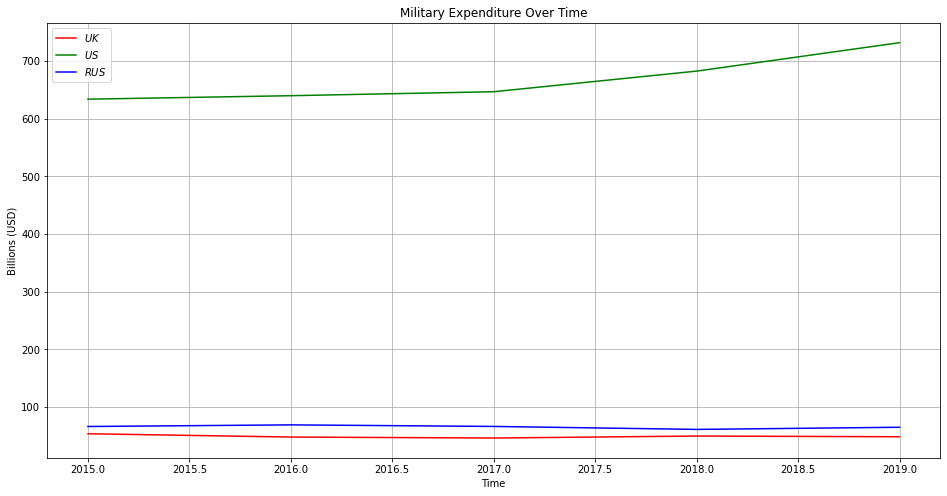

In [19]:
#Military Expenditure line Graph
plt.subplots(figsize=(16, 8))
plt.plot(UK_Mil['Year'], UK_Mil['Billions (USD)'], label='$UK$', color='red')#Plots Year on x-axis and Expenditure on y-axis as a line graph 
plt.plot(US_Mil['Year'], US_Mil['Billions (USD)'], label='$US$', color='green')#Each Nation has its own label and colour
plt.plot(RUS_Mil['Year'], RUS_Mil['Billions (USD)'], label='$RUS$', color='blue')
plt.xlabel('Time') #Axis Label
plt.ylabel('Billions (USD)')
plt.title('Military Expenditure Over Time') #Title
plt.grid(True) #Grid Lines
plt.legend() #Legend
plt.show() #Shows Plot

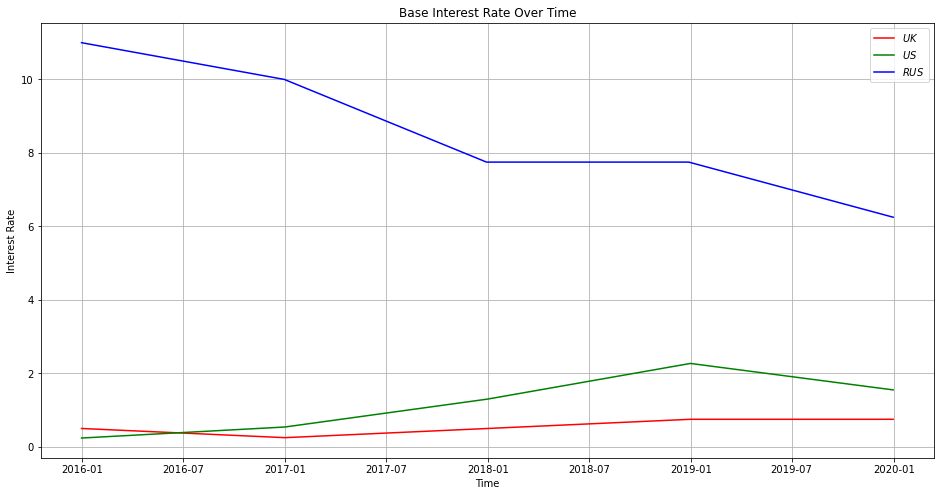

In [20]:
#Interest Rate line Graph
plt.subplots(figsize=(16, 8))
plt.plot(UK_int['Date'], UK_int['Value'], label='$UK$', color='red') #Plots Date on x-axis and Value on y-axis as a line graph 
plt.plot(US_int['Date'], US_int['Value'], label='$US$', color='green') #Each Nation has its own label and colour
plt.plot(RUS_int['Date'], RUS_int['Value'], label='$RUS$', color='blue')
plt.xlabel('Time') #Axis Label
plt.ylabel('Interest Rate')
plt.title('Base Interest Rate Over Time') #Title
plt.grid(True) #Grid Lines
plt.legend() #Legend
plt.show() #Shows Plot

Section 8: Comparative Graphical Representation of Data

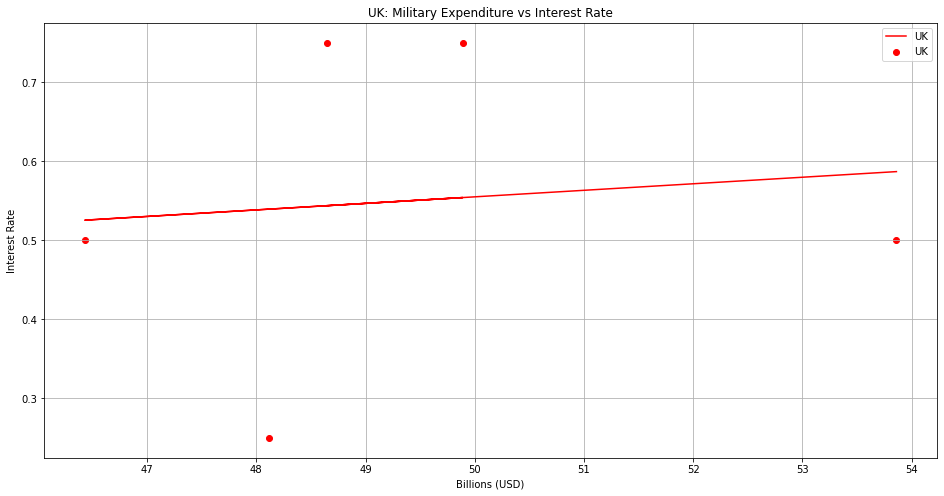

In [21]:
fig, ax = plt.subplots(figsize=(16, 8))
UK_lin=np.polyfit(UK_Mil['Billions (USD)'],UK_int['Value'],1) #Computes line of best fit for Expenditure data on Interest rates
UK_fit=np.poly1d(UK_lin) #Generates line of best fit 
ax.scatter(UK_Mil['Billions (USD)'],UK_int['Value'], label='UK', color='red') #Plots Expenditure against Interest rates as a scatter plot
plt.title('UK: Military Expenditure vs Interest Rate') #Plot title
plt.plot(UK_Mil['Billions (USD)'], UK_fit(UK_Mil['Billions (USD)']), label='UK', color='red') #Plots the line of best fit 
plt.xlabel('Billions (USD)') #Axis Labels
plt.ylabel('Interest Rate')
ax.grid(True) #Grid lines
ax.legend() #Legend
plt.show() #Shows Plot 

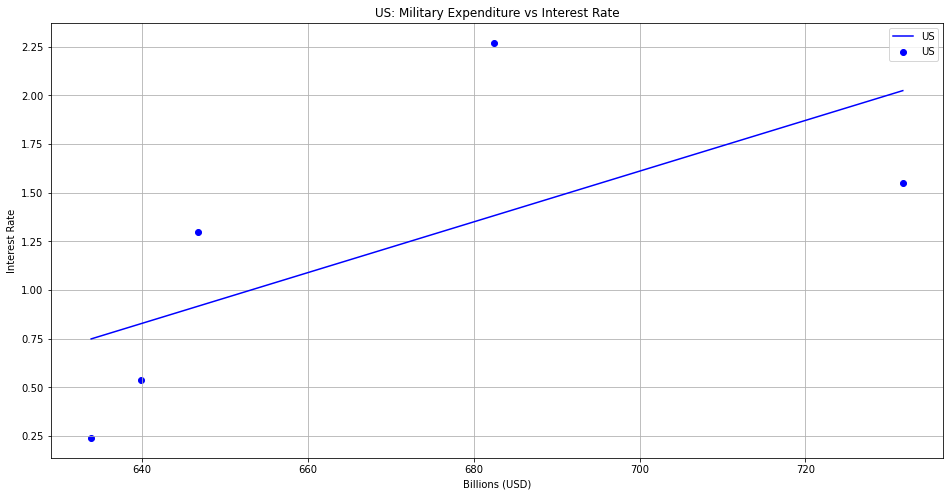

In [22]:
fig, ax = plt.subplots(figsize=(16, 8))
US_lin=np.polyfit(US_Mil['Billions (USD)'],US_int['Value'],1) #The same code has been repeated for US data series
US_fit=np.poly1d(US_lin) 
ax.scatter(US_Mil['Billions (USD)'],US_int['Value'], label='US', color='blue') 
plt.title('US: Military Expenditure vs Interest Rate') 
plt.plot(US_Mil['Billions (USD)'], US_fit(US_Mil['Billions (USD)']), label='US', color='blue')
plt.xlabel('Billions (USD)') 
plt.ylabel('Interest Rate')
ax.grid(True) 
ax.legend()
plt.show()

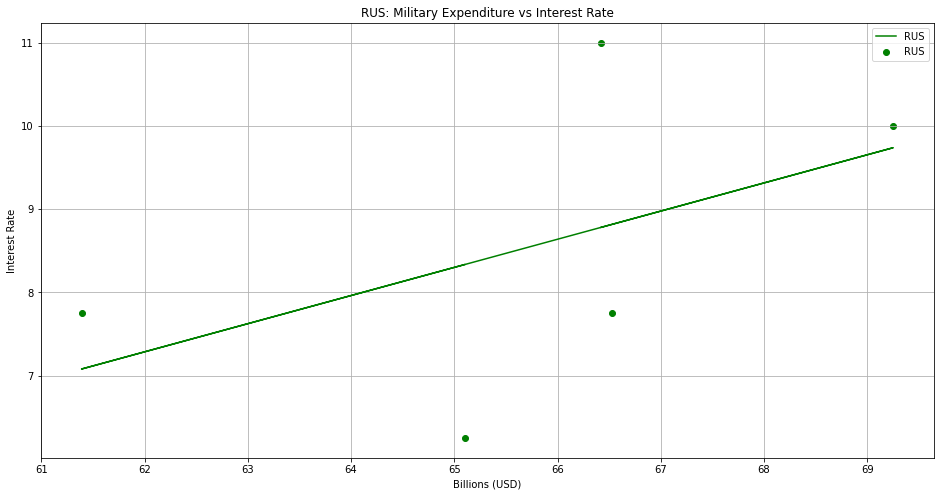

In [23]:
fig, ax = plt.subplots(figsize=(16, 8))
RUS_lin=np.polyfit(RUS_Mil['Billions (USD)'],RUS_int['Value'],1) #The same code has been repeated for Russian data series
RUS_fit=np.poly1d(RUS_lin)
ax.scatter(RUS_Mil['Billions (USD)'],RUS_int['Value'], label='RUS', color='green') 
plt.title('RUS: Military Expenditure vs Interest Rate') 
plt.plot(RUS_Mil['Billions (USD)'], RUS_fit(RUS_Mil['Billions (USD)']), label='RUS', color='green')
plt.xlabel('Billions (USD)') 
plt.ylabel('Interest Rate')
ax.grid(True) 
ax.legend()
plt.show()